<a href="https://colab.research.google.com/github/rgurve/NLP-using-Word2vec-TFIDF-Embedding-BERT-using-Deep-learning/blob/main/Twitter_Disaster_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing libraries

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import re
import os
import matplotlib.pyplot as plt
import string
import seaborn as sns
from wordcloud import WordCloud

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

plt.style.use('ggplot')

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM,Embedding,Dense,SpatialDropout1D,Dropout
from tensorflow.keras.optimizers import Adam

## Downloading Data

In [ ]:
tweet=pd.read_csv('https://raw.githubusercontent.com/laxmimerit/twitter-disaster-prediction-dataset/master/train.csv')

In [ ]:
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
tweet.shape

(7613, 5)

In [ ]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


## Exploratory Data Analysis

### Target Class Distribution

In [ ]:
plt.rcParams['figure.figsize']=[8,4]
plt.rcParams['figure.dpi'] = 120

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Real or Not Real Disaster Tweet')

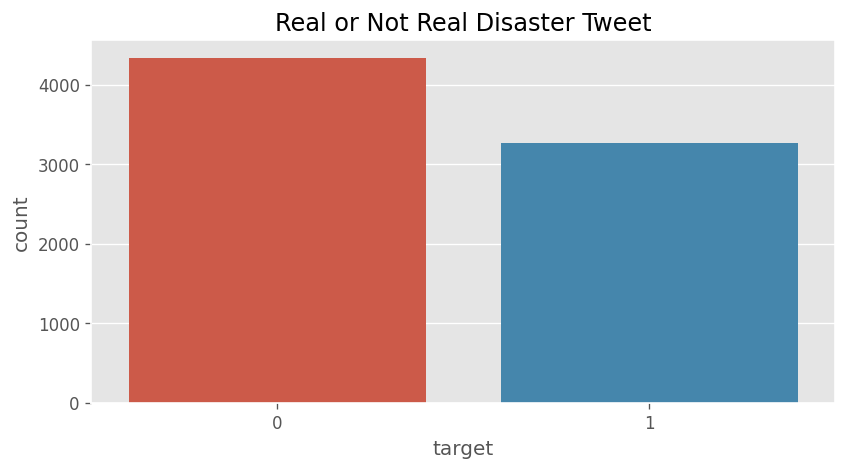

In [ ]:
sns.countplot('target',data=tweet)
plt.title('Real or Not Real Disaster Tweet')

In [ ]:
tweet['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

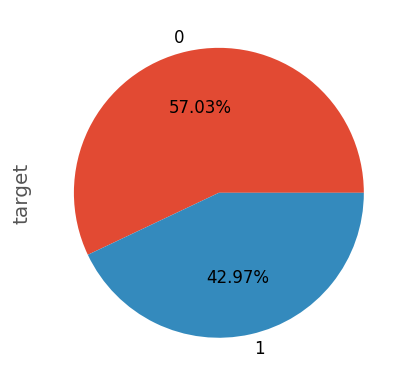

In [ ]:
tweet['target'].value_counts().plot.pie(autopct='%1.2f%%')

### Number of Character Distribution in Tweets

In [ ]:
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-k_zfgfnj
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-k_zfgfnj
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-cp36-none-any.whl size=11742 sha256=21a37add6d92d1bbfe043438a3dd4135a250471c2495c3b2e444781cf66ba6d3
  Stored in directory: /tmp/pip-ephem-wheel-cache-y8v4cd_x/wheels/a8/18/22/90afa4bd43247fb9a75b710a4a3fcd94966c022ce9e3c7d0a6
Successfully built preprocess-kgptalkie


In [ ]:
import preprocess_kgptalkie as kgp

In [ ]:
kgp.get_basic_features(tweet)

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,72,16,4.500000,6,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,73,11,6.636364,2,0,0,2,0
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,106,20,5.300000,9,0,2,2,0
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,58,8,7.250000,1,0,0,7,2
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,119,19,6.263158,6,0,0,2,0


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


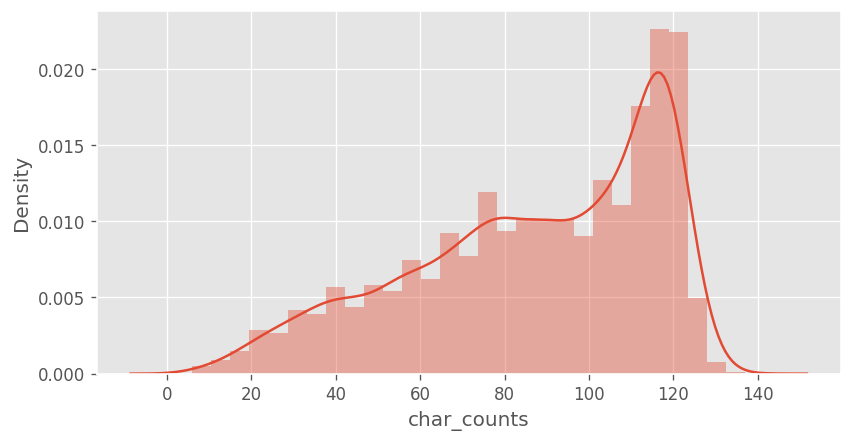

In [ ]:
sns.distplot(tweet['char_counts'])

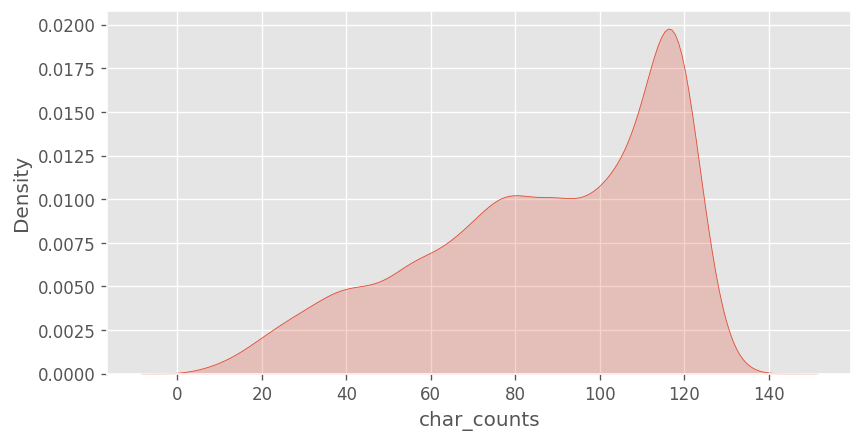

In [ ]:
sns.kdeplot(tweet['char_counts'],shade=True)

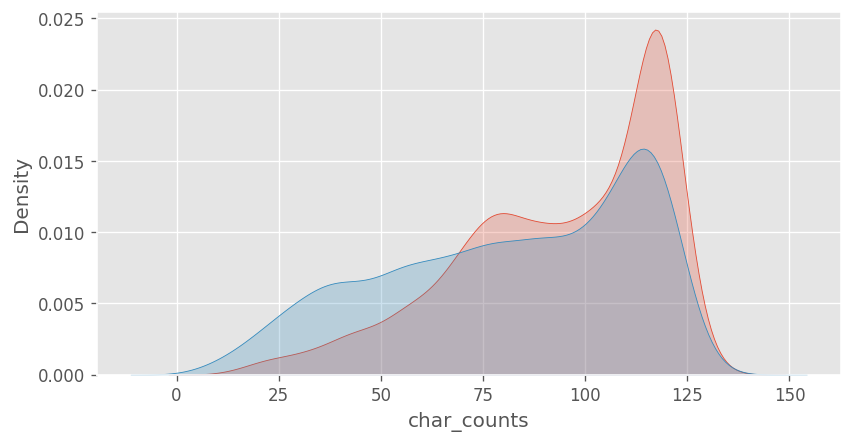

In [ ]:
sns.kdeplot(tweet[tweet['target']==1]['char_counts'],shade=True)
sns.kdeplot(tweet[tweet['target']==0]['char_counts'],shade=True)

So we see that the count of words is high when the disaster is Real

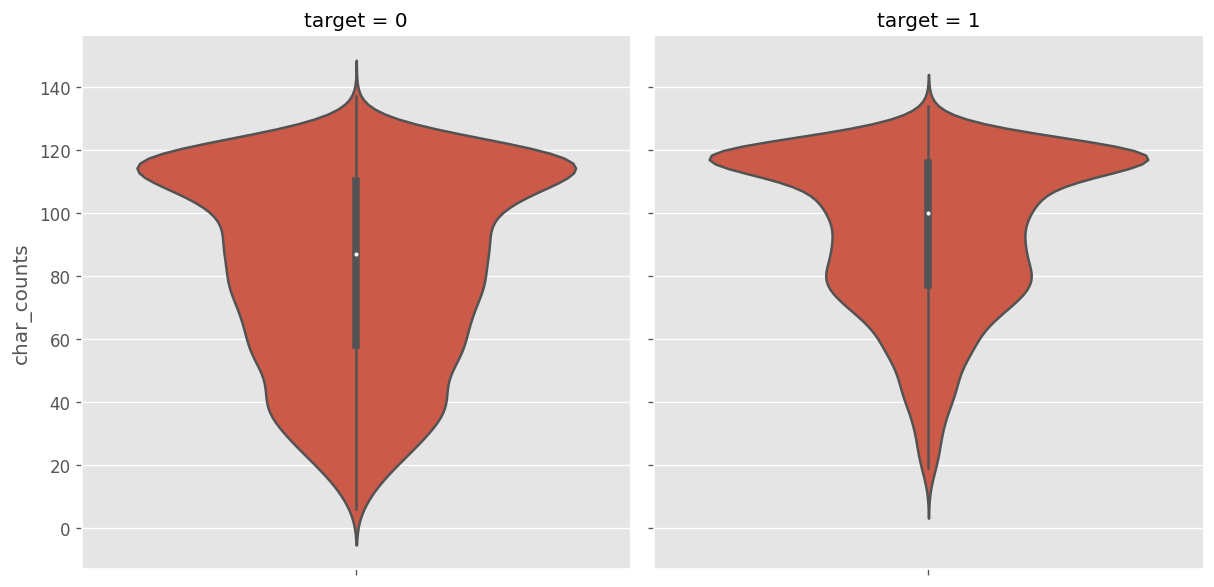

In [ ]:
sns.catplot(y='char_counts',data=tweet,kind='violin',col='target')

## Number of words,Average word length and Number of Stop words

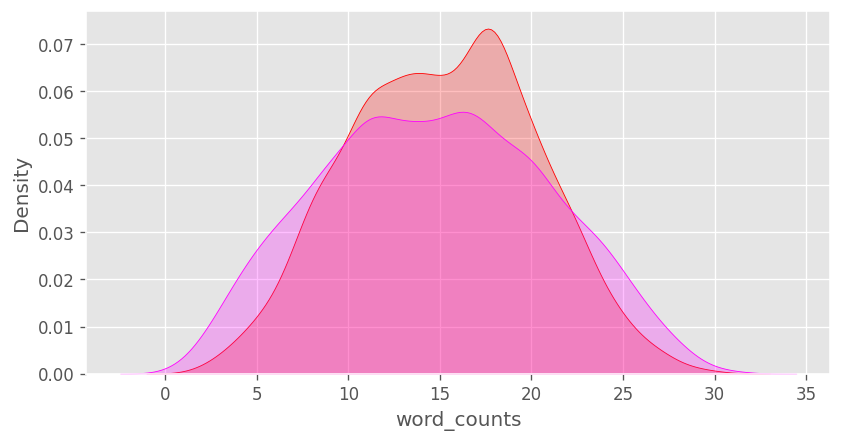

In [ ]:
sns.kdeplot(tweet[tweet['target']==1]['word_counts'],shade=True,color='Red')
sns.kdeplot(tweet[tweet['target']==0]['word_counts'],shade=True,color='Magenta')

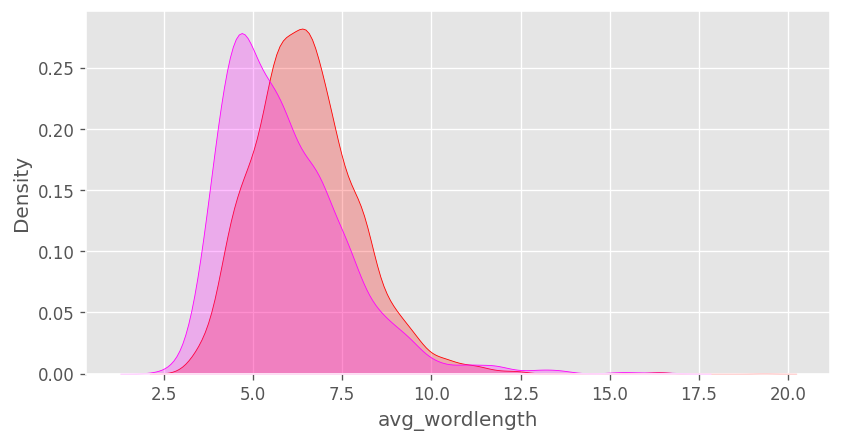

In [ ]:
sns.kdeplot(tweet[tweet['target']==1]['avg_wordlength'],shade=True,color='Red')
sns.kdeplot(tweet[tweet['target']==0]['avg_wordlength'],shade=True,color='Magenta')

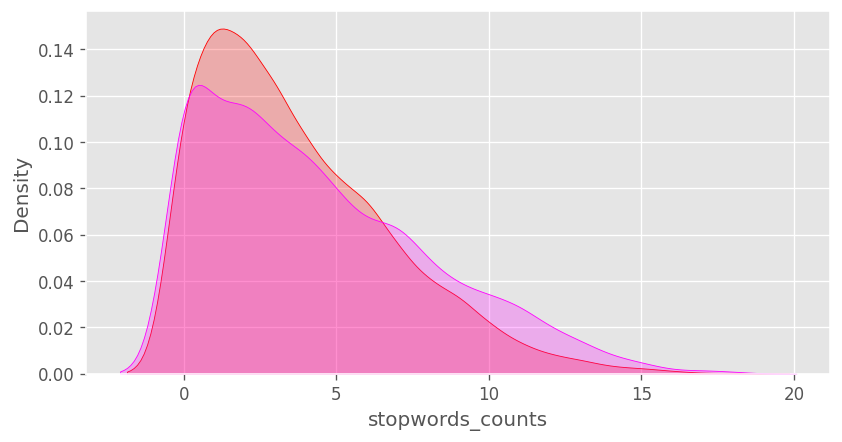

In [ ]:
sns.kdeplot(tweet[tweet['target']==1]['stopwords_counts'],shade=True,color='Red')
sns.kdeplot(tweet[tweet['target']==0]['stopwords_counts'],shade=True,color='Magenta')

In [ ]:
tweet.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'char_counts',
       'word_counts', 'avg_wordlength', 'stopwords_counts', 'hashtag_counts',
       'mentions_counts', 'digits_counts', 'uppercase_counts'],
      dtype='object')

## Most and least Common Words

In [ ]:
kgp.get_word_freqs(tweet,'text')

the            2575
a              1845
to             1805
in             1757
of             1722
               ... 
#Houston          1
7000              1
heavyweight       1
beaumont          1
Counselors        1
Length: 31924, dtype: int64

In [ ]:
freqs=kgp.get_word_freqs(tweet,'text')

In [ ]:
top20 = freqs[100:120]

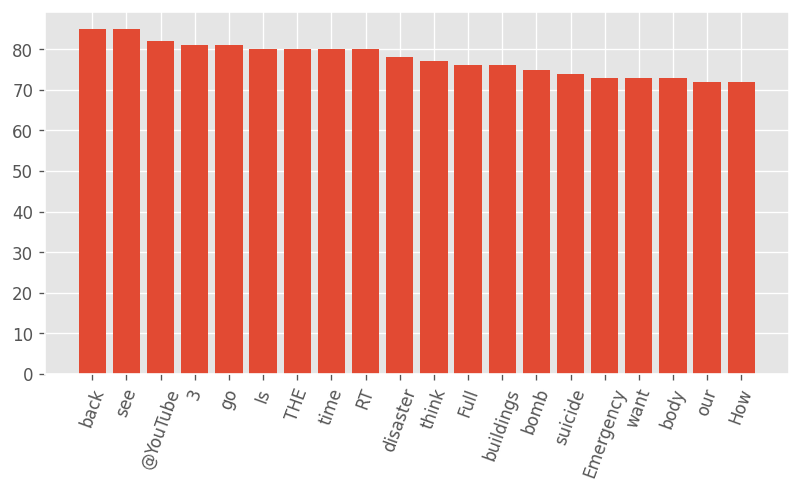

In [ ]:
plt.bar(top20.index,top20.values)
plt.xticks(rotation=70)
plt.show()

In [ ]:
least20=freqs[-20:]
least20

youÛ_                    1
idiot?                    1
namjoon's                 1
JAN/AQ                    1
whitewalkers              1
@_edvinnn                 1
http://t.co/MIs0RjxuIr    1
dfLJEV                    1
@YMcglaun                 1
rabbit                    1
lavatory'                 1
#GE's                     1
Propane                   1
discount                  1
Play-offs                 1
#Houston                  1
7000                      1
heavyweight               1
beaumont                  1
Counselors                1
dtype: int64

In [ ]:
bigram=kgp.get_ngram(tweet,'text',ngram_range=2)

In [ ]:
bigram

In [ ]:
bigram[-20:]

In [ ]:
def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    x = kgp.cont_exp(x)
    x = kgp.remove_emails(x)
    x = kgp.remove_urls(x)
    x = kgp.remove_html_tags(x)
    x = kgp.remove_rt(x)
    x = kgp.remove_accented_chars(x)
    x = kgp.remove_special_chars(x)
    x = kgp.remove_dups_char(x)
    return x

In [ ]:
tweet['text']=tweet['text'].apply(lambda x: get_clean(x))

In [ ]:
tweet.head()['text']

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    130 people receive wildfires evacuation orders...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

In [ ]:
kgp.get_ngram(tweet,'text',ngram_range=2)

## Disaster Words Visualization with Word Cloud

In [ ]:
real = kgp.get_word_freqs(tweet[tweet['target']==1], 'text')
real = ' '.join(real.index)
real

'the in of a to and is on for i at by from it that with not after this fire are was as you have my news over up more via an were disaster be people california suicide has police no who when but been killed like do will just so hiroshima than fires out crash storm families we train about now into emergency your bomb buildings 2 all mh370 there what two am nuclear wildfire video they attack get accident one bombing new burning northern minister how prime legionnaires dead bomber me some homes if war car atomic still fatal obama he years off us may collapse city debris retweet watch forest first malaysia japan latest or mass today severe water man near had earthquake those before confirmed would oil found down spill floods army 70 world warning under evacuation could home outbreak derailment wreckage injured weather saudi being migrants thunderstorm old our 40 s flood investigators can flooding during missing say u time bridge their suspect death mosque her 3 state back charged island kil

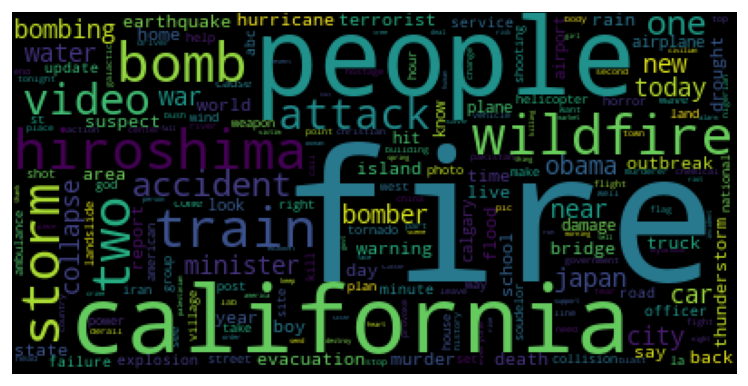

In [ ]:
word_cloud=WordCloud(max_font_size=100).generate(real)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

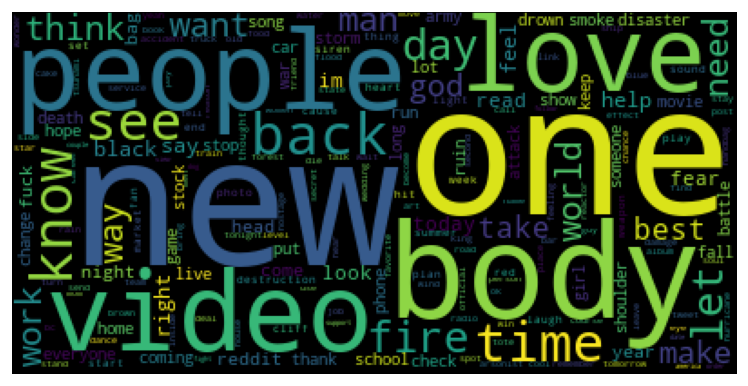

In [ ]:
#not real plot
nreal = kgp.get_word_freqs(tweet[tweet['target']==0], 'text')
nreal = ' '.join(nreal.index)
nreal

word_cloud=WordCloud(max_font_size=100).generate(nreal)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

### Classification with TFIDF and SVN

First we get the text data and then the target data

In [ ]:
text = tweet['text']
y = tweet['target']

In [ ]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(text)

In [ ]:
X.shape

(7613, 18077)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0,stratify=y)

In [ ]:
def run_SVM(clf, X_train,X_test,y_train,y_test):
  clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)

  print()
  print('Classification Report')
  print(classification_report(y_test,y_pred))

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
clf = LinearSVC()
run_SVM(clf,X_train,X_test,y_train,y_test)




Classification Report
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       869
           1       0.81      0.69      0.75       654

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.80      1523



### Classification with Word2Vec and SVM

In [ ]:
!python -m spacy download en_core_web_lg

In [ ]:
import spacy
import en_core_web_lg

In [ ]:
nlp = en_core_web_lg.load()

In [ ]:
x= 'cat dog'
doc = nlp(x)

In [ ]:
doc.vector.shape

(300,)

In [ ]:
def get_vec(x):
  doc=nlp(x)
  vec=doc.vector
  return vec


In [ ]:
tweet['vec']=tweet['text'].apply(lambda x:get_vec(x))

In [ ]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts,vec
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,57,13,4.384615,6,1,0,0,1,"[-0.26623327, 0.05843069, -0.1404636, -0.05265..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,32,7,4.571429,0,0,0,1,0,"[-0.014817425, -0.09212343, -0.10716944, -0.33..."
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,112,22,5.090909,9,0,0,1,0,"[0.0059339865, 0.016337818, -0.105279535, -0.0..."
3,6,NaN,NaN,130 people receive wildfires evacuation orders...,1,57,8,7.125000,1,1,0,1,0,"[-0.13400537, 0.25267026, 0.09032763, -0.16645..."
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,72,16,4.500000,6,2,0,0,0,"[-0.06394094, -0.01423019, 0.0063574947, 0.071..."


In [ ]:
X = tweet['vec'].to_numpy()
X = X.reshape(-1,1)

In [ ]:
X

In [ ]:
X.shape

(7613, 1)

In [ ]:
X = np.concatenate(np.concatenate(X,axis=0),axis=0).reshape(-1,300)

In [ ]:
X.shape

(7613, 300)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0,stratify=y)

In [ ]:
%%time
clf = LinearSVC()
run_SVM(clf,X_train,X_test,y_train,y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       869
           1       0.81      0.71      0.75       654

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523

CPU times: user 4.18 s, sys: 30.9 ms, total: 4.21 s
Wall time: 4.21 s


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,Dropout,Flatten
from tensorflow.keras.layers import Conv1D,MaxPool1D,GlobalAvgPool1D

In [ ]:
text

0       our deeds are the reason of this earthquake ma...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3       130 people receive wildfires evacuation orders...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    aria ahrary thetawniest the out of control wil...
7610    m194 0104 coordinated universal time5km s of v...
7611    police investigating after an ebike collided w...
7612    the latest more homes razed by northern califo...
Name: text, Length: 7613, dtype: object

In [ ]:
token=Tokenizer()
token.fit_on_texts(text)

In [ ]:
vocab_size=len(token.word_index)+1
vocab_size

18113

In [ ]:
print(token.word_index)

In [ ]:
encoded_text = token.texts_to_sequences(text)
print(encoded_text)

In [ ]:
max_length=40
X= pad_sequences(encoded_text,maxlen=max_length, padding="post")
print(X)

[[ 105 4455   21 ...    0    0    0]
 [ 183   42  221 ...    0    0    0]
 [  39 1674 1432 ...    0    0    0]
 ...
 [3273 4447 1538 ...    0    0    0]
 [  73 1088   37 ...    0    0    0]
 [   1  202   53 ...    0    0    0]]


In [ ]:
X.shape

(7613, 40)

## Adding classical machine learning algorithm

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0,stratify=y)

In [ ]:
%%time
clf = LinearSVC()
run_SVM(clf,X_train,X_test,y_train,y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.58      0.33      0.42       869
           1       0.43      0.68      0.53       654

    accuracy                           0.48      1523
   macro avg       0.51      0.51      0.48      1523
weighted avg       0.52      0.48      0.47      1523

CPU times: user 682 ms, sys: 9.06 ms, total: 691 ms
Wall time: 712 ms


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


This produces very low accuracy.
So we will apply a deep learning model over here

Embedding will create a vector internally in the deep learning model

In [ ]:
vec_size = 100

model = Sequential()
model.add(Embedding(vocab_size,vec_size, input_length=max_length))

model.add(Conv1D(32,2,activation='relu'))
model.add(MaxPool1D(2))
model.add(Dropout(0.5))

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16,activation='relu'))

model.add(GlobalAvgPool1D())

model.add(Dense(1,activation='sigmoid'))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 100)           1811300   
_________________________________________________________________
conv1d (Conv1D)              (None, 39, 32)            6432      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 19, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 32)            0         
_________________________________________________________________
dense (Dense)                (None, 19, 32)            1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 32)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 19, 16)            5

In [ ]:
%%time
model.compile(optimizer='adam',loss='binary_crossentropy' ,metrics=['accuracy'])
model.fit(X_train,y_train,epochs=5,validation_data=(X_test,y_test))


Epoch 1/5
191/191 [==============================] - 12s 23ms/step - loss: 0.6818 - accuracy: 0.5524 - val_loss: 0.5094 - val_accuracy: 0.7866
Epoch 2/5
191/191 [==============================] - 4s 20ms/step - loss: 0.4211 - accuracy: 0.8323 - val_loss: 0.4489 - val_accuracy: 0.8135
Epoch 3/5
191/191 [==============================] - 4s 20ms/step - loss: 0.2215 - accuracy: 0.9197 - val_loss: 0.5232 - val_accuracy: 0.7991
Epoch 4/5
191/191 [==============================] - 4s 20ms/step - loss: 0.1424 - accuracy: 0.9486 - val_loss: 0.6705 - val_accuracy: 0.7951
Epoch 5/5
191/191 [==============================] - 4s 20ms/step - loss: 0.1093 - accuracy: 0.9651 - val_loss: 0.7243 - val_accuracy: 0.7800
CPU times: user 30.9 s, sys: 2.57 s, total: 33.5 s
Wall time: 27.6 s


In [ ]:
def get_encoded(x):
  x=get_clean(x)
  x=token.texts_to_sequences([x])
  x=pad_sequences(x,maxlen=max_length,padding='post')
  return x

In [ ]:
x= 'i am thrilled to see this'
vec=get_encoded(x)

In [ ]:
vec

array([[  6,  29,   4, 102,  19,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0]], dtype=int32)

In [ ]:
np.argmax(model.predict(vec),axis=-1)

array([0])

### BERT Model

In [ ]:
!pip install ktrain

In [ ]:
import pandas as pd


In [ ]:
tweet=pd.read_csv('https://raw.githubusercontent.com/laxmimerit/twitter-disaster-prediction-dataset/master/train.csv')

In [ ]:
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:

import ktrain

In [ ]:
from ktrain import text

In [ ]:
(X_train,y_train),(X_test,y_test),preproc = text.texts_from_df(train_df=tweet, text_column='text', label_columns=['target'],  maxlen=40, preprocess_mode='bert')

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [ ]:
model = text.text_classifier(name='bert', train_data=(X_train,y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 40
done.


In [ ]:
learner=ktrain.get_learner(model=model, train_data=(X_train,y_train),val_data=(X_test,y_test),batch_size=64)

In [ ]:
learner.fit_onecycle(lr=2e-5,epochs=1)



begin training using onecycle policy with max lr of 2e-05...
108/108 [==============================] - 104s 796ms/step - loss: 0.5988 - accuracy: 0.6652 - val_loss: 0.4230 - val_accuracy: 0.8241


In [ ]:
learner.fit_onecycle(lr=2e-5,epochs=3)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
108/108 [==============================] - 82s 758ms/step - loss: 0.3673 - accuracy: 0.8510 - val_loss: 0.4387 - val_accuracy: 0.8215
Epoch 2/3
108/108 [==============================] - 82s 756ms/step - loss: 0.3451 - accuracy: 0.8622 - val_loss: 0.4465 - val_accuracy: 0.8097
Epoch 3/3
108/108 [==============================] - 81s 755ms/step - loss: 0.2771 - accuracy: 0.8987 - val_loss: 0.4588 - val_accuracy: 0.8123


In [ ]:
learner.fit_onecycle(lr=2e-4,epochs=3)



begin training using onecycle policy with max lr of 0.0002...
Epoch 1/3
108/108 [==============================] - 82s 756ms/step - loss: 0.3248 - accuracy: 0.8756 - val_loss: 0.7600 - val_accuracy: 0.7362
Epoch 2/3
108/108 [==============================] - 82s 756ms/step - loss: 0.3375 - accuracy: 0.8621 - val_loss: 0.4583 - val_accuracy: 0.8294
Epoch 3/3
108/108 [==============================] - 82s 756ms/step - loss: 0.1641 - accuracy: 0.9410 - val_loss: 0.5820 - val_accuracy: 0.8202


In [ ]:
# to fing learning rate
#learner.lr_find()
#learner.lr_plot()

In [ ]:
predictor = ktrain.get_predictor(learner.model,preproc)

In [ ]:
data=['i met you today by accident','today i had a car accident','i am injured']

In [ ]:
predictor.predict(data[1])

'target'